# 8.2 Exercises: Time Series Modeling
# Rahul Rajeev

In [126]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [127]:
# dataset
retail = pd.read_csv('us_retail_sales.csv')
retail.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1992,146925,147223,146805,148032,149010,149800,150761.0,151067.0,152588.0,153521.0,153583.0,155614.0
1,1993,157555,156266,154752,158979,160605,160127,162816.0,162506.0,163258.0,164685.0,166594.0,168161.0
2,1994,167518,169649,172766,173106,172329,174241,174781.0,177295.0,178787.0,180561.0,180703.0,181524.0
3,1995,182413,179488,181013,181686,183536,186081,185431.0,186806.0,187366.0,186565.0,189055.0,190774.0
4,1996,189135,192266,194029,194744,196205,196136,196187.0,196218.0,198859.0,200509.0,200174.0,201284.0


In [128]:
# one column for date-time, one column for values

# date-time column
import datetime

start_date = datetime.date(1992,1,1)
end_date = datetime.date(2021,12,1)

date_range = pd.date_range(start_date, end_date)
date_range = date_range[date_range.day==1]

dates = date_range.tolist()

# values column
import itertools

retail_values = retail.drop('YEAR', axis=1)
sales = []

for val in retail_values.values:
    sales.append(val)

sales_list = list(itertools.chain.from_iterable(sales))

In [129]:
# finalized dataframe
retail_final = pd.DataFrame({'date': dates, 'sales': sales_list})
retail_final

,date,sales
0,1992-01-01,146925.0
1,1992-02-01,147223.0
2,1992-03-01,146805.0
3,1992-04-01,148032.0
4,1992-05-01,149010.0
...,...,...
355,2021-08-01,NaN
356,2021-09-01,NaN
357,2021-10-01,NaN
358,2021-11-01,NaN


**1. Plot the data with proper labeling and make some observations on the graph**

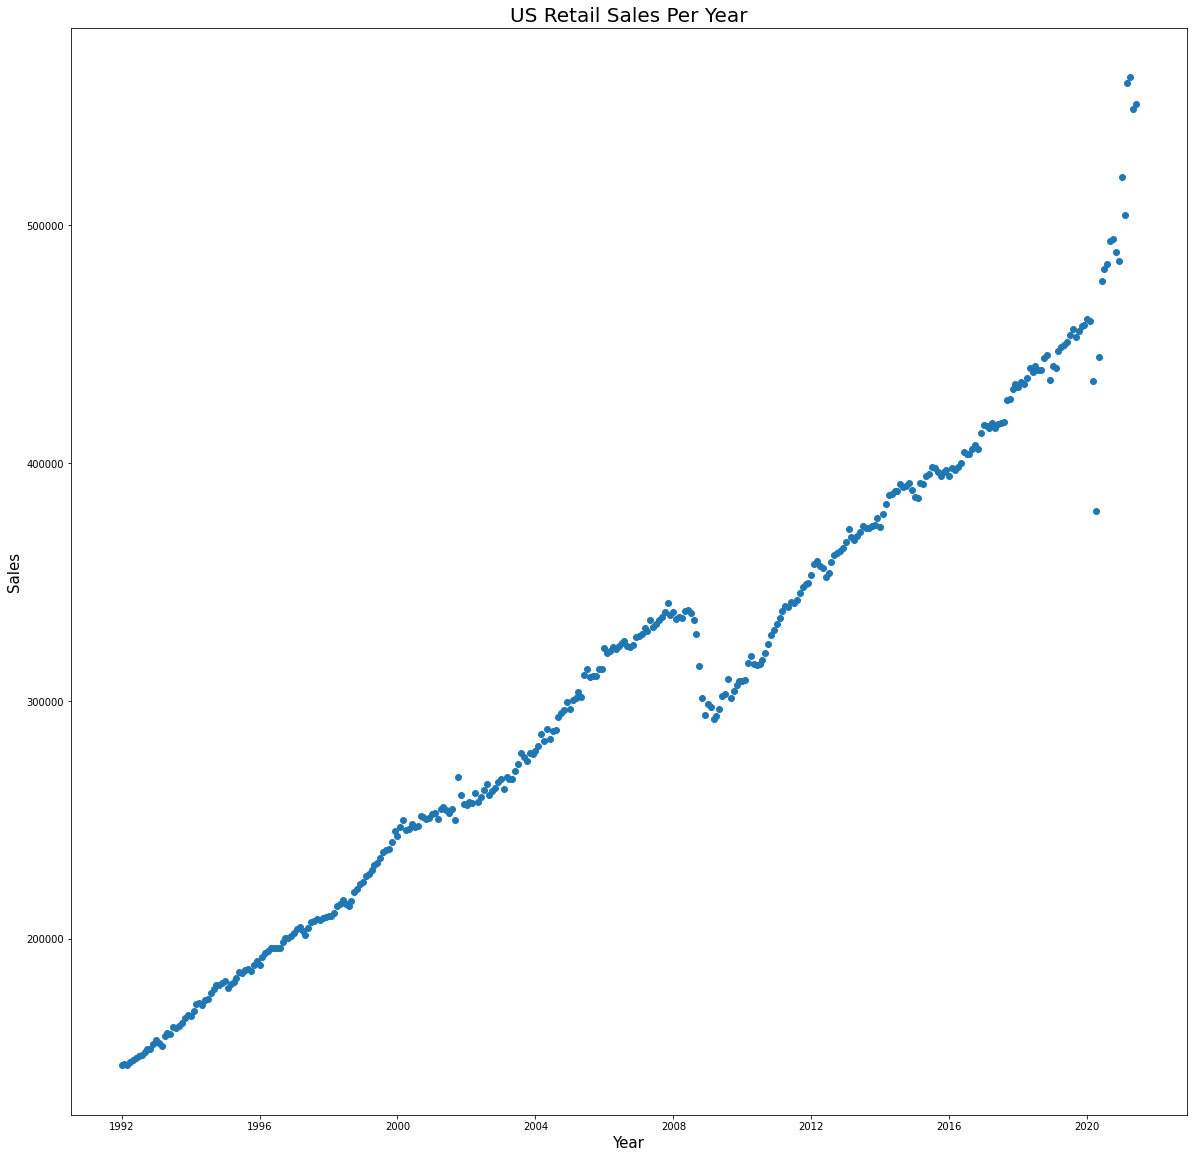

In [130]:
plt.figure(figsize=(20,20))
plt.scatter(retail_final['date'], retail_final['sales'])
plt.xlabel('Year', fontsize=15)
plt.ylabel('Sales', fontsize=15)
plt.title('US Retail Sales Per Year', fontsize=20)
plt.show()

**Observations:** Sales seem to be continuously increasing from 1992 up until a sudden decline around 2009-2010. It then resumes increasing again until after 2020 where the sales have a wider range of values, below and above the already apparent trend. In short, the sales values have a sudden decrease and increase at a much faster rate than before each month. 

In [131]:
retail_final.tail(24)

,date,sales
336,2020-01-01,460586.0
337,2020-02-01,459610.0
338,2020-03-01,434281.0
339,2020-04-01,379892.0
340,2020-05-01,444631.0
341,2020-06-01,476343.0
342,2020-07-01,481627.0
343,2020-08-01,483716.0
344,2020-09-01,493327.0
345,2020-10-01,493991.0


**Observations (cont.):** As seen in the dataframe, there is a sharp drop in retail sales around april of 2020 and that could be attributed to the onset of the covid pandemic. Shortly after as people prepared to stay at home, they continued to buy increasing amounts of products leading to the very fast increase of sales. However, it is not known what the retail sales were after July of 2021.

**2. Split this data into a training and test set. Use the last year of data (July 2020 – June 2021) of data as your test set and the rest as your training set.**

In [132]:
# first delete null values
from datetime import date
cleaned = retail_final.dropna()

# find index of july 2020 (2020-07-01) and then split
strdate = cleaned['date'].astype('str').tolist()
strdate.index('2020-07-01')

cleaned = cleaned.set_index('date')

In [133]:
# training
training = cleaned[:342]

# test
test = cleaned[342:]

**3. Use the training set to build a predictive model for the monthly retail sales.**

The time series data appears to be non-stationary, but just to be sure, let's perform a dickey-fuller statistical test for significance.

In [134]:
from statsmodels.tsa.stattools import adfuller

In [135]:
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(cleaned.sales.values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: 1.4490526692726289
ADF p-values: 0.9973259755033455
ADF number of lags used: 12
ADF number of observations: 341
ADF critical values: {'1%': -3.449673193310592, '5%': -2.8700533746644323, '10%': -2.5713055939491403}
ADF best information criterion: 6846.754053139283


The null hypothesis of the ADF test is that a unit root is present in the time series. The alternative hypothesis is that the data is stationary.

If I set a level of significance to be 0.05, we see that the p-value is much greater. In this case, we cannot reject the null hypothesis and will have to assume that the data is non-stationary. As you have seen the data, you know that there is a trend, so this also confirms the result we obtained.

<AxesSubplot:xlabel='date'>

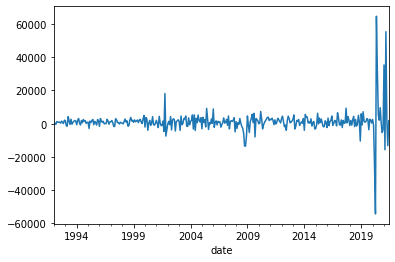

In [136]:
prev_sales_value = cleaned.sales.shift()
differenced_sales = cleaned.sales - prev_sales_value
differenced_sales.plot()

Since I haven't done much with classical time series models, I will try normal regression models first like linear and Random Forest. If I don't find much success, I will then try the classical. 

In [137]:
months = [x.month for x in cleaned.index]
years = [x.year for x in cleaned.index]
day = [x.day for x in cleaned.index]

# convert into one matrix
X = np.array([day, months, years]).T

# resplit into training and test
X_train = X[:342]
Y_train = cleaned['sales'][:342]

X_test = X[342:]
Y_test = cleaned['sales'][342:]

Text(0.5, 1.0, 'Model Predictions for the Train Set')

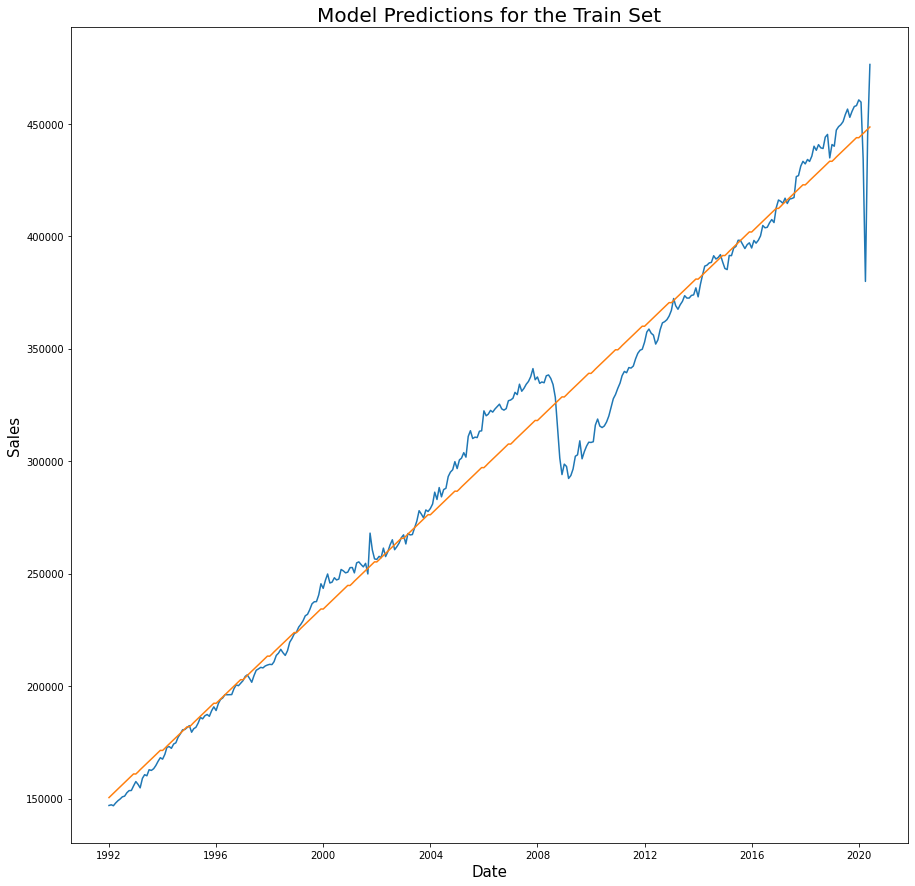

In [153]:
from sklearn.linear_model import LinearRegression
my_lr = LinearRegression()
my_lr.fit(X_train, Y_train)

# predict on the same period
preds = my_lr.predict(X_train)

# plot what has been learned
plt.figure(figsize=(15,15))
plt.plot(cleaned.index[:342], Y_train)
plt.plot(cleaned.index[:342], preds)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Sales', fontsize=15)
plt.title('Model Predictions for the Train Set', fontsize=20)

The linear regression model cuts through all of the twists and turns in the time series data, so it may be clear that it's not a great fit for the entirety of the data, but just to be sure we can calculate some evaluation metrics on the test data to see whether its a good predictor.

In [139]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

def evaluate(model):        
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    model_score = r2_score(Y_test, pred)
    
    #s = cross_val_score(model, X, Y, cv=5, scoring='r2', n_jobs=-1)
        
    print("R^2 score:", model_score)
    #print("Cross Validation Score: {:0.5} ± {:0.5}".format(s.mean().round(5), s.std().round(5)))
    print("RMSE:", mean_squared_error(Y_test, pred)**.5)
    
    plt.figure(figsize=(15,15))
    plt.plot(cleaned.index[342:], Y_test)
    plt.plot(cleaned.index[342:], pred)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Sales', fontsize=15)
    plt.title('Model Predictions for the Test Set', fontsize=20)

**4. Use the model to predict the monthly retail sales on the last year of data.**

**5. Report the RMSE of the model predictions on the test set.**

I will repeatedly go through steps 4 and 5 for each of the models I choose to test. Meaning I will use the model and also report the RMSE of the model.

R^2 score: -3.645400677324732
RMSE: 66511.08639264108


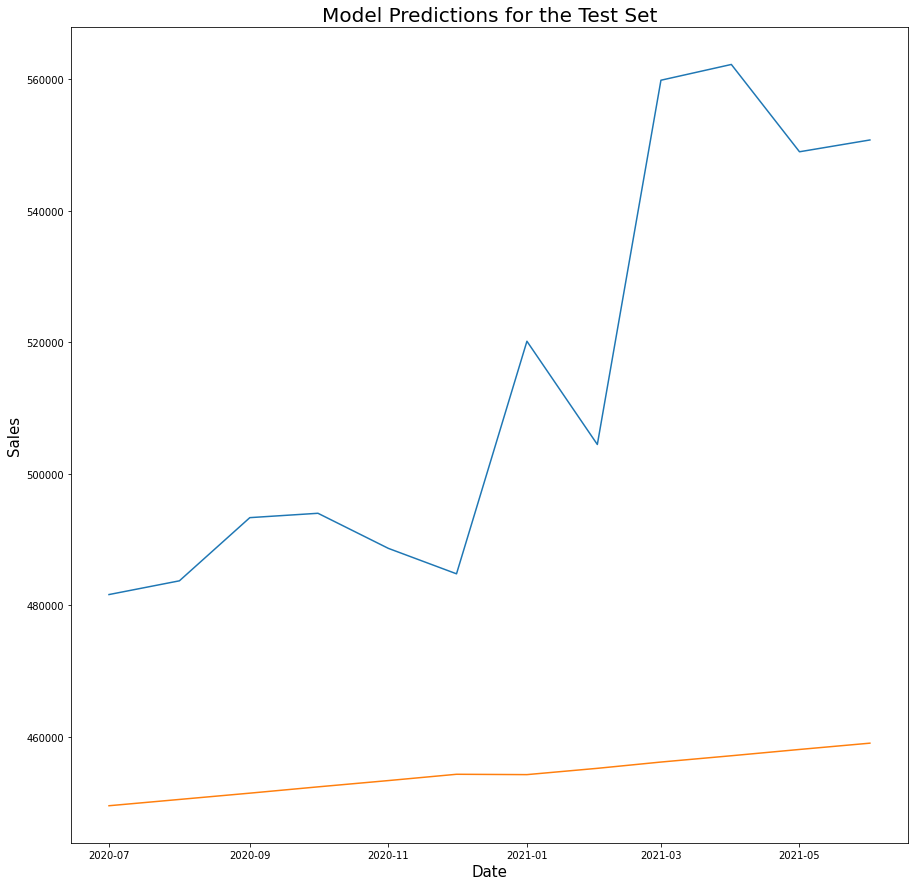

In [140]:
evaluate(my_lr)

R^2 score is very negative and RMSE is very large, so a linear regression model might not be a good fit. Let's try random forest regression. 

Text(0.5, 1.0, 'Model Predictions for the Train Set')

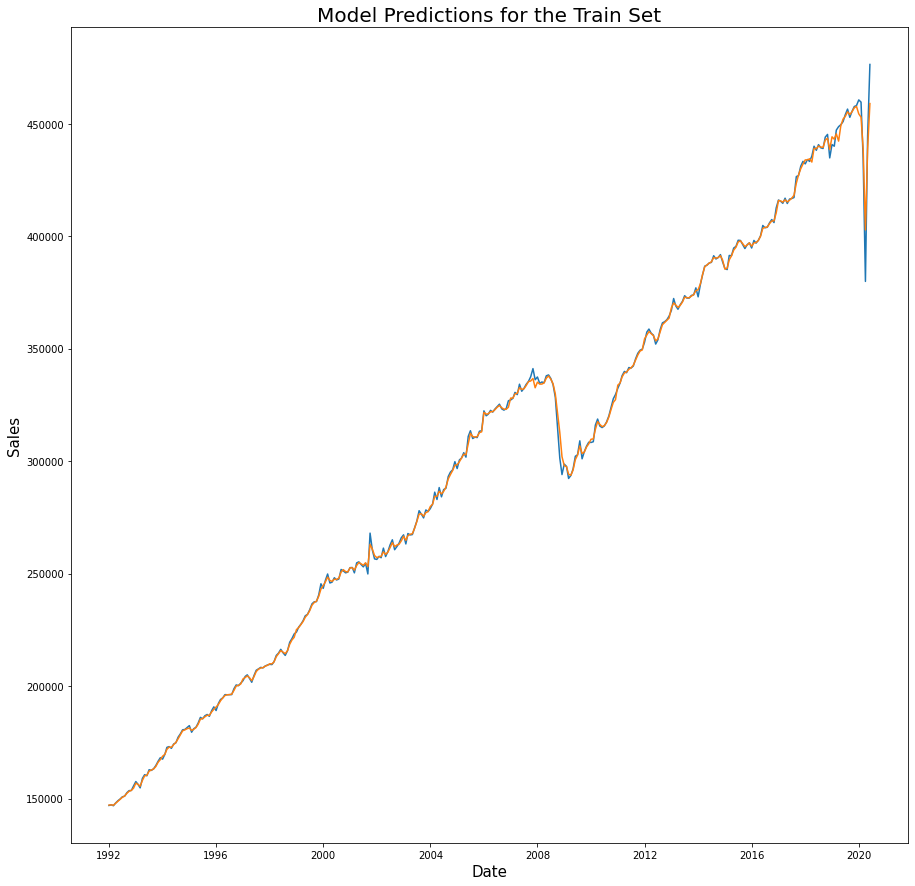

In [152]:
from sklearn.ensemble import RandomForestRegressor

# fit the model
my_rf = RandomForestRegressor()
my_rf.fit(X_train, Y_train)

preds = my_rf.predict(X_train)

# plot what has been learned
plt.figure(figsize=(15,15))
plt.plot(cleaned.index[:342], Y_train)
plt.plot(cleaned.index[:342], preds)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Sales', fontsize=15)
plt.title('Model Predictions for the Train Set', fontsize=20)

The Random Forest Regressor accounts for the variability much better, but we should still see whether it can predict the test set correctly. 

R^2 score: -5.221393332963527
RMSE: 76970.84988814543


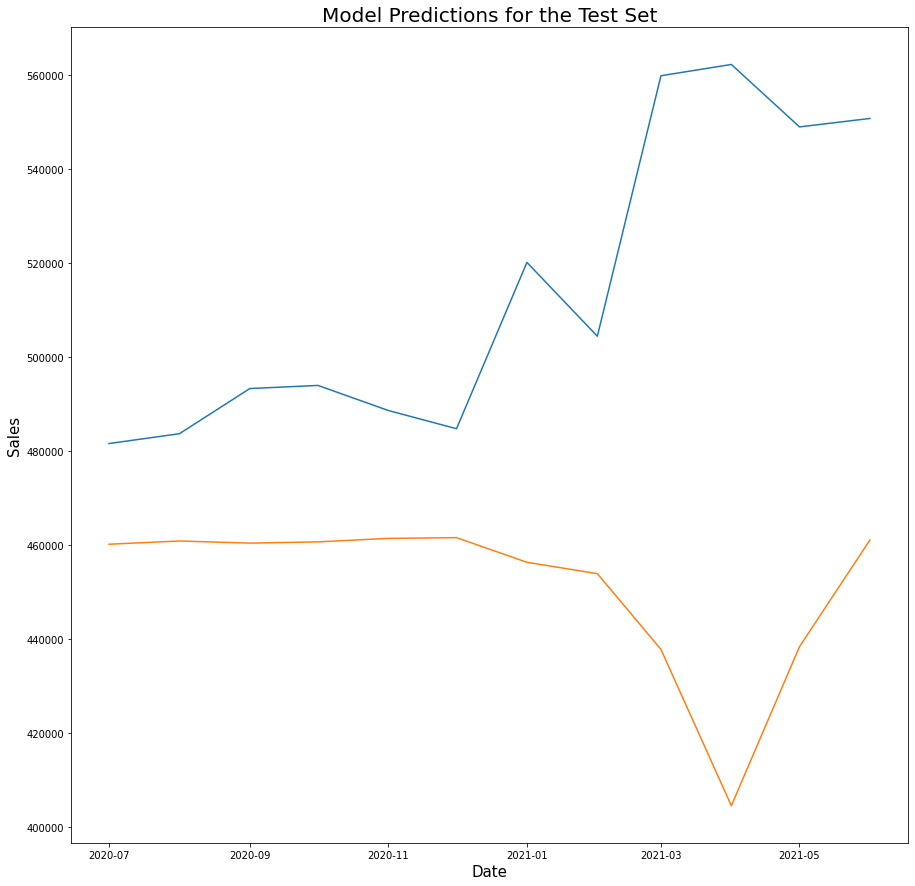

In [142]:
evaluate(my_rf)

Same as the linear regression model, although the model fits the training data well, it still doesn't predict the test data great with a very negative R^2 score and a larger RMSE . Now, I will try using ARIMA and classical time series modeling. 

In [143]:
import warnings
warnings.filterwarnings('ignore')

In [144]:
from statsmodels.tsa.arima_model import ARIMA
#import statsmodels.api as sm
# I can use the normal time series column instead of having the matrix of days, years, and months

# training
training = cleaned[:342]

# test
test = cleaned[342:]

In [145]:
model=ARIMA(training,order=(1,1,1))
model_fit=model.fit()

In [146]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.sales   No. Observations:                  341
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3431.691
Method:                       css-mle   S.D. of innovations           5678.420
Date:                Tue, 25 Jul 2023   AIC                           6871.382
Time:                        23:51:49   BIC                           6886.709
Sample:                    02-01-1992   HQIC                          6877.489
                         - 06-01-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           919.3314    155.498      5.912      0.000     614.560    1224.103
ar.L1.D.sales     0.5466      0.098      5.593      0.000       0.355       0.738
ma.L1.D.sales    -0.7724      0.067    -11.596      0.000      -0.903      -0.642
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8295           +0.0000j            1.8295            0.0000
MA.1            1.2947           +0.0000j            1.2947            0.0000
-----------------------------------------------------------------------------
"""

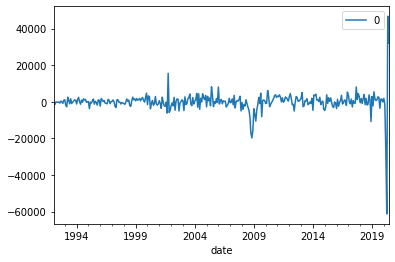

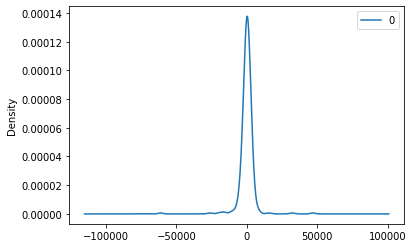

_______________________________
Summary Statistics of Residuals
_______________________________
                  0
count    341.000000
mean      -7.684628
std     5686.788585
min   -61239.740038
25%    -1202.754064
50%      234.156578
75%     1646.295319
max    46751.985751


In [154]:
from matplotlib import pyplot
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print('_______________________________')
print('Summary Statistics of Residuals')
print('_______________________________')
print(residuals.describe())

As we see above, mean is not exactly zero that means there is some bias in the data.

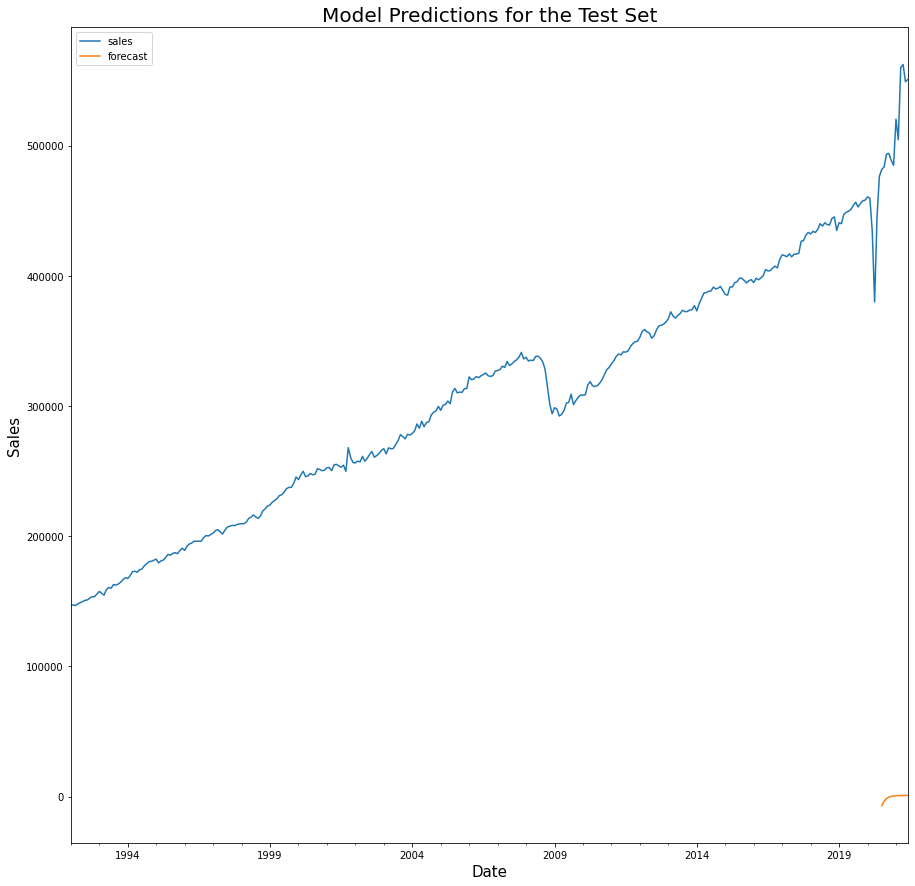

In [151]:
cleaned['forecast']=model_fit.predict(start=342,end=353, dynamic=True)
cleaned[['sales','forecast']].plot(figsize=(15,15))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Sales', fontsize=15)
plt.title('Model Predictions for the Test Set', fontsize=20)
plt.show()

It doesn't appear that ARIMA provides great forecasting, but here is the RMSE for the model. 

In [149]:
print("RMSE:", mean_squared_error(cleaned.sales[342:], cleaned.forecast[342:])**.5)

RMSE: 515766.3404740557


As evident from both the graphed forecast and the RMSE calculated, ARIMA doesn't appear to be a great model for predicting the data. If I were to continue, I would try seasonal ARIMA, but I think because of the sudden deviation from trend in the last year of data, I would assume that it would be very difficult to get a great prediction based on previous data.

Looking at all of the models, I don't see any of the models being successfull at predicting the last year of data. Studying more about classical time series modeling because it is a bit unclear to me at the moment and possibly attempting to use deep learning models could be the way to get better predictions in the future.


**Citations:**

Time series analysis using Arima from Statsmodels. Time Series Analysis Using ARIMA From StatsModels. (n.d.). https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/ 

Korstanje, J. (2023, April 19). How to select a model for Your time series prediction task [guide]. neptune.ai. https://neptune.ai/blog/select-model-for-time-series-prediction-task 







____
_
_
_